# TC data sample comparisons: 
We need to compare groups of indicators taken from Transparent cities Transparency dataset. The gropus are based on two criteria:
1. Complex vs simple indicators: a simple indicator takemes little to moderate effort to implement and is valued at 1 point max. A complex indicator takes more effort to implement and is valued at 2 points max. Read the latest Transparency methodology at http://transparentcities.in.ua for more.
2. Imperative vs non-imperative indicators: contents of an indicator may either be regulated by law (imperative) or be purely recommendational (non-imperative). A middle-ground case is when an indicator may be based on the legislation when implemented one way and may not in another.

This notebook is devoted to the complex vs simple comparison. Our goals are:
- To see if their means differ
- To see if the differences are statisically significant.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

In [2]:
#load the dataset
data = pd.read_excel("data/210903 зведена база 2020.xlsx")

Let's add a binary variable for complexity.

In [3]:
data['complexity'] = data['maxPoint'].map({1.0:'simple', 2.0:'complex'})
#check if the operation went well - there should be two categories
data['complexity'].unique()

array(['simple', 'complex'], dtype=object)

We will not compare absolute scores (which obviously differ a lot) but the average % of completion, measured as city's point divided by maximum point.

In [4]:
data['percent_implemeted'] = data['point']/data['maxPoint']

Calculate mean of both groups

In [5]:
all_implemented = np.array(data['percent_implemeted'])
simple_implemented = np.array(data[data['complexity']=='simple']['percent_implemeted'])
complex_implemented = np.array(data[data['complexity']=='complex']['percent_implemeted'])

In [6]:
# calculate means of both groups
simple_mean = simple_implemented.mean()
complex_mean = complex_implemented.mean()

# the difference between the means of two groups is our ground truth
gT = simple_mean - complex_mean

print(f'Mean implementation of simple indicators: {np.round(simple_mean, 3)*100}%')
print(f'Mean implementation of complex indicators: {np.round(complex_mean, 3)*100}%')
print(f'Difference of means: {np.round(gT, 3)*100}%')


Mean implementation of simple indicators: 42.8%
Mean implementation of complex indicators: 33.2%
Difference of means: 9.6%


Now that we know the means and their difference, we can formulate our hypotheses.
- **Null hypothesis**: there is no difference between % of implementation in two groups of indicators.
- **Alternative hypothesis***: there is a difference between % of implementation in two groups of indicators.

## Normality test
Now that we know the difference of averages is about 10%, let's check the distributions within our "complex" and "simple" groups. Based on the distributions, we'll decide if we should use parametric or non-parametric test to assess the significance.

In [7]:
# for simple indicators
stats.normaltest(simple_implemented)

NormaltestResult(statistic=134307.81210266633, pvalue=0.0)

In [8]:
#for complex indicators
stats.normaltest(complex_implemented)

NormaltestResult(statistic=958.8718971194835, pvalue=6.075934934167223e-209)

The test has shown that the distributions are as far from normal as it gets. Let's see how they look.

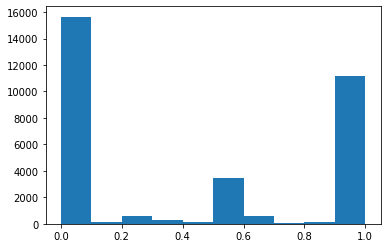

In [9]:
np.random.seed(1)
plt.hist(simple_implemented)
plt.show()

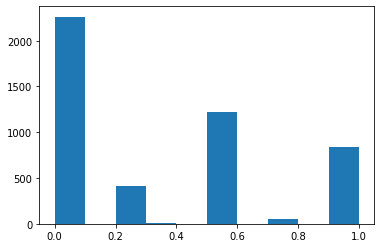

In [10]:
np.random.seed(1)
plt.hist(complex_implemented)
plt.show()

## Test
We'll discover the statistical significance of our data with permutation test.

In [11]:
# create a copy of array with % of implementation ot be shuffled for permutations
all_copy = copy.copy(all_implemented)

In [12]:
# get the sizes of the samples
simple_size = len(simple_implemented)
complex_size = len(complex_implemented)

In [13]:
# create an array to srore permutations
permutations = []
# set the number of permutations
n = 1000

In [14]:
# permute the data

for i in range(0, n):
    np.random.shuffle(all_copy)
    permutations.append(np.abs(all_copy[0:simple_size].mean() - all_copy[simple_size:].mean()))

In [15]:
# our p-value is the proportion of cases where the differene is higher or equal to our 
# ground truth divided by n of permutations
p_val = len(np.where(permutations>=gT)[0])/n
print(f'p-value: {p_val}')

p-value: 0.0


Our p-value is 0.0, meaning that no mean from the shuffled samples was larger than the difference between the means of the actual groups. Which also means that **we can safely reject the null hypothesis**. 

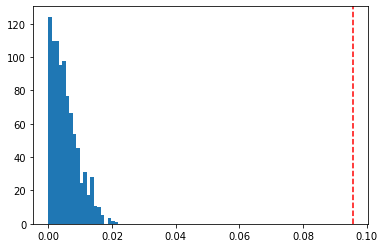

In [16]:
# let's also look at the permutations distribution
fig, ax = plt.subplots()

ax.hist(permutations, bins=20, density=True)
ax.axvline(gT, ls='--', color='r')
plt.show()